In [5]:
%pip install convertdate

  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached PyMeeus-0.5.11-py3-none-any.whl



You should consider upgrading via the 'c:\users\krister\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import convertdate
import re
import json

In [320]:
main_df = pd.read_parquet('../data/RZ_processed.parquet')

In [9]:
weekdays = ['Montag', 'Montage', 'Dienstag', 'Dienstage', 'Dinstag', 'Mittwoch', 'Donnerstag', 'Donnerstage',
            'DonnerStag', 'DienStag', 'DienStage', 'DinStag',
            'Freitag', 'Freytag', 'Freitage', 'Sonntag', 'Sonnabend', 'Sonntage', 'Stag', 'Tage',
            'Gestern', 'Morgen']
months = ['Januar', 'Februar', 'März', 'April', 'Juni', 'Juny', 'Juli', 'July', 'August',
          'October', 'Oktober', 'November', 'December', 'Dezember']
times_of_day = ['Abend', 'Heute']
currencies = ['Thlr']
other = ['Fremde', 'Hotel', 'Adler', 'Rathhaus', 'Riga-Rathhaus', 'Riga-RathhauS', 'Riga-Schloß', 'Geldkurs', 'Hause',
         'Tgbf', 'Börse', 'Pastorat', 'Senat', 'Schmidt', 'Verwaltung', 'Bekanntmachungen', 'Anzeige', 'Jahre',
         'Tagesbefehle', 'Schloß', 'Ritterhause', 'Weihnachtsabend']

exceptions = weekdays + months + times_of_day + currencies + other

In [300]:
with open('../data/re_exceptions.txt', 'r', encoding='utf8') as f:
    exceptions = []
    for line in f.readlines():
        exceptions.append(line.strip('\n'))

In [350]:
with open('../data/re_pattern2.txt', 'r', encoding='utf8') as f:
    pattern = re.compile(f.read(), flags=re.MULTILINE)

In [307]:
def pattern_test():

    for ix, row in main_df.iterrows():
        matches = list(re.finditer(pattern, row.full_text))
        if len(matches) > 0:
            
            return row.full_text, matches
        

In [309]:
text, matches = pattern_test()
print(text)
print(matches[0].groupdict())

Lissabon, den 30. Oktober.

	Die Staatszeitung versichert, daß btt französische Geschäftsträger unsenn Ministerium angezeigt: Frankreich habe keine feindliche Absicht wider Spanien und noch, weniger wider Portugal, und die Pyre» väen» Armee keinen andern Zweck, al-5

	baß Frankreich nicht durch Spanien, bei der Gährung, die in dem letzteren Herr» sche, beunruhigt werde. Auch unser Geschäftsträger zu London ist von Herrn Canning im Namen der britischen Regierung benachrichtigt worden, daß das Ge» rücht einer Invasion der Halbinsel völlig falsch sey, und daß in allen Fällen Eng« land seinen alten Freund und Bundcsge» Nossen, Portugal, nie verlassen werde.
{'placename': 'Lissabon', 'DATE2': None, 'date2': None, 'month2': None, 'date2_par': None, 'month2_par': None, 'DATE': '30. Oktober', 'date': '30', 'date_par': None, 'month': 'Okt', 'year': None}


In [448]:
def get_text(ix, window):
    window_before, window_after = window, window
    if window_before > df.loc[ix, 'start']:
        window_before = df.loc[ix, 'start']
        
    return main_df.loc[df.loc[ix, 'doc_id'], 'full_text'][df.loc[ix, 'start']-window_before:df.loc[ix, 'end']+window_after]
    
    
def get_example(placename, window=200):
    example = df.loc[df.placename == placename].sample(1)
    ix = example.index.values[0]
    doc_id = example.doc_id.values[0]
    print('doc_id: ', doc_id, '\n') 
    if window == 'full':
        print(main_df.loc[doc_id, 'full_text'], '\n')
    else:
        print(get_text(ix, window), '\n')
    for match in re.finditer(pattern, main_df.loc[doc_id, 'full_text']):
        print(match.groupdict())
        
        
def extract_data_from_match(match):
    m = match.groupdict()
    if m['DATE2'] is None:
        return [m['placename'], m['date'], m['date_par'], m['month'], m['month2'], m['year'],
                match.span()[0], match.span()[1]]
    elif m['DATE'] is None:
        return [m['placename'], m['date2'], m['date2_par'], m['month2'], m['month2_par'], m['year'],
                match.span()[0], match.span()[1]]

        
def scan_placenames_dates(main_df):
    
    results = []
    
    for ix, row in tqdm(main_df.iterrows()):
        matches = list(re.finditer(pattern, row.full_text))
        for m in matches:
            #results.append([ix, row.date] + list(m.groupdict().values()) + [m.span()[0], m.span()[1]])
            results.append([ix, row.date] + extract_data_from_match(m))
        
    result_df = pd.DataFrame(columns=['doc_id',
                                      'doc_date',
                                      'placename',
                                      'day',
                                      'day2',
                                      'month',
                                      'month2',
                                      'origin_year',
                                      'start',
                                      'end'],
                             data=results).fillna(pd.NA)
    
    result_df['doc_date'] = pd.to_datetime(result_df['doc_date'], format='%Y-%m-%d')
    #result_df['doc_year'] = result_df['doc_date'].dt.year
    
    result_df['origin_year'].fillna(0, inplace=True)
    result_df['origin_year'] = result_df['origin_year'].astype(int)
    result_df['origin_year'].replace(0, pd.NA, inplace=True)
    
    for col in ['day', 'day2']:
        
        result_df[col] = result_df[col].str.lstrip('( ').str.strip('.) ')
        result_df[col].fillna(0, inplace=True)
        result_df[col] = result_df[col].astype(int)
        result_df[col] = result_df[col].apply(lambda x: x if (x in range(1,32)) else pd.NA)
        result_df[col].replace(0, pd.NA, inplace=True)
        
    return result_df[~result_df.placename.isin(exceptions)]

In [447]:
df

,doc_id,doc_date,placename,day,day2,month,month2,origin_year,start,end,doc_year
0,0,1802-01-01,St. Petersburg,20,<NA>,12,<NA>,<NA>,0,32,1802
1,1,1802-01-01,Paris,18,<NA>,12,<NA>,<NA>,0,27,1802
2,2,1802-01-01,Haag,22,<NA>,12,<NA>,<NA>,0,27,1802
3,3,1802-01-01,Zürich,16,<NA>,12,<NA>,<NA>,0,28,1802
4,4,1802-01-01,Wien,19,<NA>,12,<NA>,<NA>,0,26,1802
...,...,...,...,...,...,...,...,...,...,...,...
259360,289703,1888-12-31,New York,9,28,1,12,<NA>,2009,2044,1888
259361,289704,1888-12-31,PeterSbnrs,31,<NA>,12,<NA>,<NA>,0,26,1888
259362,289704,1888-12-31,St. Petersburg,31,<NA>,12,<NA>,<NA>,1560,1586,1888
259363,289704,1888-12-31,Berlin,11,<NA>,1,<NA>,<NA>,2559,2578,1888


In [423]:
df = scan_placenames_dates(main_df)

0it [00:00, ?it/s]

In [80]:
def example():
    
    example_ix = df.sample().doc_id.values[0]

    for ix, row in df[df.doc_id == example_ix].iterrows():
        print(row.loc[['placename', 'date_full', 'date2_full']], '\n')
    print('\n\n', main_df.loc[row['doc_id'], 'full_text'])

In [370]:
print(df.placename.value_counts().sum())
print(df.placename.value_counts()[lambda x: x >= 30].sum())

248416
225449


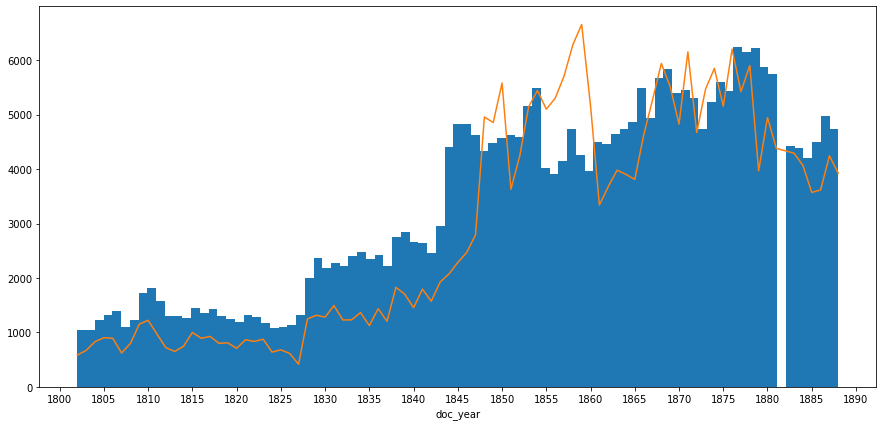

In [378]:
plt.figure(figsize=(15,7))
main_df.year.hist(bins=87)
df.groupby('doc_year')['doc_year'].count().plot()
plt.xticks(range(1800,1891,5))
plt.show()

In [424]:
with open('../data/placename_replacement_dict.json', 'r', encoding='utf8') as f:
    placename_replacement_dict = json.load(f)

df.placename.replace(placename_replacement_dict, inplace=True)

In [427]:
df[df.day.isna()]

,doc_id,doc_date,placename,day,day2,month,month2,origin_year,start,end,doc_year
30,46,1802-01-15,Amiens,<NA>,<NA>,Dec,<NA>,<NA>,0,27,1802
4653,5991,1806-12-12,St. Petersburg,<NA>,<NA>,Nov,<NA>,<NA>,0,29,1806
9966,12953,1811-08-30,Riga,<NA>,<NA>,Aug,<NA>,<NA>,1351,1372,1811
10421,13683,1812-02-17,Riga,<NA>,<NA>,Feb,<NA>,1812,1005,1031,1812
10533,13839,1812-03-23,Kurs,<NA>,<NA>,Mär,<NA>,<NA>,37,57,1812
...,...,...,...,...,...,...,...,...,...,...,...
258966,289156,1888-11-18,Berlin,<NA>,18,Nov,<NA>,<NA>,37,66,1888
259245,289558,1888-12-19,Tarragdna,<NA>,19,Dec,<NA>,<NA>,2083,2113,1888
259280,289603,1888-12-23,Riga,<NA>,<NA>,Dec,<NA>,<NA>,9,30,1888
259335,289678,1888-12-30,Neapel,<NA>,<NA>,Dec,<NA>,<NA>,2011,2035,1888


In [428]:
def cleanup_dates(df):
    
    #df = df.copy()
    
    month_dict = dict(zip(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun',
                           'Jul', 'Aug', 'Sept', 'Okt', 'Nov', 'Dec'], range(1,13)))
    
    for col in ['month', 'month2']:
    
        df[col] = df[col].str.capitalize()
        df[col].replace({'Dez': 'Dec', 'Mar': 'Mär', 'Oct': 'Okt', '0ct': 'Okt', '0kt': 'Okt', 'Ocl': 'Okt',
                         'Spt': 'Sept', 'Jnl': 'Jul', 'Jnn': 'Jun', 'Juu': 'Jun', 'Jnu': 'Jun', 'May': 'Mai'}, inplace=True)
        
        df[col].replace(month_dict, inplace=True)
        df.loc[df[col].isin(['C', 'C.', 'D. m', 'D. m.']), col] = df.loc[df[col].isin(['C', 'C.', 'D. m', 'D. m.']), 'doc_date'].dt.month
        df.loc[df[col].isin(['V. m', 'V. m.']), 'month'] = (df.loc[df[col].isin(['v. M', 'V. m.']), 'doc_date'] - pd.DateOffset(months=1)).dt.month - 1
        
        df[col] = df[col].fillna(0).astype(int)
        df[col] = df[col].apply(lambda x: x if (x in range(1,13)) else pd.NA)
    
    #df.day = df.day.fillna(0).astype(int)
    #df.day = df.day.apply(lambda x: x if (x in range(1,32)) else pd.NA)
    #
    #df.day2 = df.day2.fillna(0).astype(int)
    #df.day2 = df.day2.apply(lambda x: x if (x in range(1,32)) else pd.NA)
    
    return df 

In [429]:
df = cleanup_dates(df)

In [437]:
def verify_dates(ix, df=df):
    
    """Function to find the logically correct date from the information found by the regular expression.
    Has different approaches depending on the number of dates and months detected. In the case of multiple
    possibilities, returns the earlier one (corresponding to the Julian calendar)."""
    
    #print(df.loc[ix,['day', 'day2', 'month', 'doc_date']].values)
    
    day, day2, month, month2, origin_year, doc_date = [value if type(value) != pd._libs.missing.NAType else None
                                          for value in df.loc[ix,['day', 'day2', 'month', 'month2', 'origin_year', 'doc_date']].values]
    
    path = []
    
    # if 
    if day is None or month is None:
        path.append(0)
        return pd.NA, path
    
    # two dates, two months
    if None not in [day, day2, month, month2]:
        path.append(1)
        
        if origin_year:
            origin_date = min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
            
        # exception for december
        elif (month in (11, 12) or month2 in (11, 12)) and doc_date.month in (1, 2):
            path.append(1.1)
            possible_origin_dates = []
            for m in [month, month2]:
                origin_year = doc_date.year-1 if m == 12 else doc_date.year
                possible_origin_dates.append(
                        pd.to_datetime(f'{str(origin_year)}-{m}-{day}', format='%Y-%m-%d', errors='coerce'))
                    
            origin_date = min(possible_origin_dates)
        
        # normal proceeding, no december in any of the two dates
        else:
            path.append(1.2)
            # julian is the smaller one
            origin_date = min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
       
    
    # two dates, one month
    elif day and day2 and month:
        path.append(2)
        
        if origin_year:
            origin_date = min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
        
        # if month is the same or precedes the publication month
        if month == doc_date.month or month < doc_date.month:
            path.append(2.1)
            
            # julian is the smaller one
            origin_date = min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
       
        # if month follows publication month
        elif month > doc_date.month:
            path.append(2.2)
            
            # exception for december
            if month == 12 and doc_date.month == 1:
                origin_date = min(
                    pd.to_datetime(f'{str(doc_date.year-1)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                    pd.to_datetime(f'{str(doc_date.year-1)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'))                 
            else:
                return pd.NA, path
            
            
    # one day, one month
    elif day and month:
        path.append(3)            
        
        # if month precedes publication month
        if month < doc_date.month:
            path.append(3.1)
            # (probably) julian
            origin_date = pd.to_datetime(f'{origin_year if origin_year else str(doc_date.year)}-{month}-{day}',
                                         format='%Y-%m-%d', errors='coerce')
        
        # if month is the same as publication month
        elif month == doc_date.month:
            path.append(3.2)
            
            # if the day is later than the publication day, within the same month
            if day > doc_date.day:
                path.append(3.21)
                
                # origin is gregorian, convert to julian first, then apply
                try:
                    day_jul = convertdate.julian.from_gregorian(year=origin_year if origin_year else doc_date.year,
                                                                month=month, day=day)
                except ValueError:
                    return pd.NA
                origin_date = pd.to_datetime(f'{str(day_jul[0])}-{str(day_jul[1])}-{str(day_jul[2])}',
                                             format='%Y-%m-%d', errors='coerce')
            
            # if the day precedes the publication day, within the same month
            else:
                path.append(3.22)
                # origin is julian, apply directly to datetime
                origin_date = pd.to_datetime(f'{origin_year if origin_year else str(doc_date.year)}-{month}-{day}',
                                             format='%Y-%m-%d', errors='coerce')
        
        
        # if month is greater than publication month
        elif month > doc_date.month:
            path.append(3.3)
            
            if origin_year:
                origin_date = pd.to_datetime(f'{origin_year}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
                
            # exception for december
            elif month in (11, 12) and doc_date.month in (1, 2):
                path.append(3.31)
                # origin is from last year - probably in julian b/c is smaller that doc_date and there is no day2
                origin_date = pd.to_datetime(f'{str(doc_date.year-1)}-{month}-{day}',
                                             format='%Y-%m-%d', errors='coerce')
                
            else:
                path.append(3.32)
                # origin is from next month, thus in gregorian
                try:
                    day_jul = convertdate.julian.from_gregorian(year=doc_date.year, month=month, day=day)
                except ValueError:
                    return pd.NA
                origin_date = pd.to_datetime(f'{str(day_jul[0])}-{str(day_jul[1])}-{str(day_jul[2])}',
                                             format='%Y-%m-%d', errors='coerce')
            
    return origin_date #,path

In [441]:
origin_dates = []
for ix in tqdm(df.index):
    origin_dates.append(verify_dates(ix, df))

#df['origin_date'] = origin_dates

  0%|          | 0/248416 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [442]:
df_sample = df.sample(10000)

origin_dates = []
for ix in tqdm(df_sample.index):
    origin_dates.append(verify_dates(ix, df_sample))

df_sample['origin_date'] = origin_dates

  0%|          | 0/10000 [00:00<?, ?it/s]

In [105]:
df.dropna(subset=['origin_date'], inplace=True)
df['origin_date'] = pd.to_datetime(df.origin_date)

KeyError: ['origin_date']

In [456]:
loaded_df = pd.read_csv('../data/processed_data.tsv', sep='\t', encoding='utf8').convert_dtypes()

In [455]:
loaded_df[(loaded_df.delta > 350) & (df.origin_)]

,doc_id,doc_date,placename,day,day2,month,month2,origin_year,start,end,origin_date,delta
8848,16096,1813-12-31,Berlin,1,NaN,1,NaN,NaN,0,23,1813-01-01,364
23903,44822,1832-12-31,Hamburg,1,NaN,1,NaN,NaN,0,24,1832-01-01,365
25912,49714,1834-12-31,Braunschweig,1,NaN,1,NaN,NaN,0,29,1834-01-01,364
28901,56684,1837-12-29,Hamburg,1,NaN,1,NaN,NaN,0,24,1837-01-01,362
30593,59411,1838-12-28,Leipzig,1,NaN,1,NaN,NaN,0,24,1838-01-01,361
...,...,...,...,...,...,...,...,...,...,...,...,...
68963,279961,1886-12-29,Wien,8,27.0,1,12.0,NaN,0,32,1886-01-08,355
68964,279962,1886-12-29,Wien,8,27.0,1,12.0,NaN,0,32,1886-01-08,355
68967,279991,1886-12-31,Stuttgart,10,NaN,1,NaN,NaN,0,22,1886-01-10,355
69845,289643,1888-12-27,Berlin,8,NaN,1,NaN,NaN,0,18,1888-01-08,354


In [278]:
loaded_df.doc_date = pd.to_datetime(loaded_df.doc_date, format='%Y-%m-%d', errors='coerce')
loaded_df.origin_date = pd.to_datetime(loaded_df.origin_date, format='%Y-%m-%d', errors='coerce')

In [297]:
loaded_df[loaded_df.delta < 0].sample(10)

,doc_id,doc_date,placename,day,day2,month,month2,start,end,year,origin_date,delta
115503,129162,1856-01-18,Kapitulation,29,NaN,9,NaN,1244,1275,1856,1856-09-17,-243
275995,251798,1880-02-25,Circulars,12,NaN,10,NaN,701,727,1880,1880-09-30,-218
302539,274997,1885-11-14,Wien,12,NaN,12,NaN,2323,2342,1885,1885-11-30,-16
269790,244907,1879-01-18,Vereins,23,NaN,10,NaN,2991,3015,1879,1879-10-11,-266
304147,276726,1886-04-15,Brustkreuz,26,NaN,5,NaN,11111,11134,1886,1886-05-14,-29
248243,227806,1876-03-09,Kaufmannschaft,6,NaN,11,NaN,5878,5909,1876,1876-10-25,-230
24519,34412,1828-06-02,Traktates,6,NaN,7,NaN,744,768,1828,1828-06-24,-22
303144,275619,1886-01-11,Schweden,13,NaN,7,NaN,12837,12859,1886,1886-07-01,-171
249081,228505,1876-04-24,Bauerverordnung,13,NaN,11,NaN,1277,1310,1876,1876-11-01,-191
157573,152996,1861-09-06,Rechberg,20,NaN,10,NaN,3117,3142,1861,1861-10-08,-32


In [60]:
# vorigen monat on valepidi!?
# 12-1 asemele 11/12-1/2
# pigem teha nii, et kui pole just järgmine kuu, on automaatselt eelmine aasta?

In [282]:
def debug_example(ix):
    doc_ix = loaded_df.loc[ix, 'doc_id']
    print(doc_ix)
    print(loaded_df.loc[ix, 'placename'])
   # print(main_df.loc[doc_ix, 'date'], '\n')
    print(loaded_df.loc[ix, ['day', 'day2', 'month', 'month2', 'doc_date']], '\n')
    print(verify_dates(ix, loaded_df))
    print(main_df.loc[doc_ix, 'full_text'])

In [286]:
loaded_df.loc[108836, 'doc_date'] - (loaded_df.loc[108836, 'origin_date'] - pd.)

Timedelta('-160 days +00:00:00')

In [298]:
debug_example(302539)

274997
Wien
day                          12
day2                        NaN
month                        12
month2                      NaN
doc_date    1885-11-14 00:00:00
Name: 302539, dtype: object 

(Timestamp('1885-12-12 00:00:00'), [1, 1.2])
König Alfons von Spanien †.

	Run haben fich die HiobSposten, welche feit Monaten von einem gefährlichen Gesundheitszustand de» König» Alfons uissen wollten uud von der Madrider Regierung immer wieder dementirt wurden, in erschreckender Weise bewahrheitet: Der junge König, der übermorgen, am 28. (16.) No. vember, sein achtundzwanzigste» Lebensjahr vollendet haben würde, ist gestern gestorben, und so sehr man auch, nach den Meldungen der letzten Tage, auf die Wahrscheinlichkeit seine» nahen Ende» Vorbereitet war, erst der Eintritt desselben wirkt mit der Macht einer politischen Katastrophe.
Zunächst ist eS die Empfindung einer tiefen Rührung und Trauer, welche daS so frühe Er» löschen dieses jungen Fürstenlebens erweckt; denn ausgestattet mit d

In [83]:
day_jul = convertdate.julian.from_gregorian(year=1856, month=3, day=2)
print(day_jul)

(1856, 2, 19)


In [252]:
sample = main_df.sample()
print(sample.date.values[0], '\n')
print(sample.full_text.values[0])

1833-06-22 

Die Behörden sind äußerst wachsam und beobachte» M mentltch alle Fremden mit großer Aufmerksamkeil. 3 Tagen haben viele Haussuchungen stattgefunden. 2*° auö Frankreich angekommene Reisende, die man im dacht des Einverständnisses mit dem &lt;?r-Minister werbe hat, stehen unter strenger Aufsicht. wurde ein Französischer HandlungSkommiS in de« %4p dllcke verhaftet, wo er nach Bayonne abreisen wollte; f«n Koffer ward geöffnet, und in einer alten Bn'eftasche fanden sich Briefe ohne Unterschrift an den Grafen von VIM und an Herrn Calomarde vor, in denen von der flttflf M Infanten Don Carlos und von eine« Kern von «nbängm,

	Madrid, den 11. Juni.

	die in den nördlichen Provinzen, namentlich in Katalonien, versammelt seyen, die Rede war. Die Regierung hat sofort Stafetten an die Generalkaoi:aine dieser Provinzen mit energischen Befehlen abgesandt, den Unruhen durch Verhaftung der Rädelsführer vorzube igen.
AuS Bilbao wird gemeldet, daß d.r dorfige Magistrat sich dem Einrücken eia

In [194]:
test_df

,date,year,month,day,pub,heading,full_text,href,text_len,placename,origin_date,origin_month,heading2
158691,1862-12-12,1862,12,12,Rigasche Zeitung,Holland.,"Holland.\n\n\tHaag, 13. (1.) December. sKöln.Z...",https://proc.dom.lndb.lv/file.axd?id=15287209&...,696,None,None,None,Holland
120911,1854-04-05,1854,4,5,Rigasche Zeitung,Inländische Nachrichten.,Inländische Nachrichten.\n\n\tTt. Petersburg. ...,https://proc.dom.lndb.lv/file.axd?id=12135834&...,7271,None,None,None,Inländische Nachrichten
218663,1874-07-13,1874,7,13,Rigasche Zeitung,Das Attentat und die Reaction.,Das Attentat und die Reaction.\n\n\tIn dem Kam...,https://proc.dom.lndb.lv/file.axd?id=11835060&...,9780,None,None,None,Das Attentat und die Reaction
158839,1862-12-22,1862,12,22,Rigasche Zeitung,Oesterreich.,"Oesterreich.\n\n\tWien, 27. (15.) December. De...",https://proc.dom.lndb.lv/file.axd?id=4374749&a...,2573,None,None,None,Oesterreich
204682,1871-10-13,1871,10,13,Rigasche Zeitung,Benedetti und Lessinnes,"Benedetti und Lessinnes\n\n\tL. Berlin, 22. (1...",https://proc.dom.lndb.lv/file.axd?id=13290475&...,5345,None,None,None,Benedetti und Lessinnes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66739,1841-09-02,1841,9,2,Rigasche Zeitung,"Paris, den 3. September.","Paris, den 3. September.\n\n\tIm „Moniteur par...",https://proc.dom.lndb.lv/file.axd?id=8950120&a...,4589,Paris,3,Sept,Paris
4746,1806-01-20,1806,1,20,Rigasche Zeitung,"Folgende Personen sind gesonnen, bon hier Zu r...","Folgende Personen sind gesonnen, bon hier Zu r...",https://proc.dom.lndb.lv/file.axd?id=8565650&a...,717,None,None,None,Folgende Personen sind gesonnen von hier zu re...
10539,1810-03-26,1810,3,26,Rigasche Zeitung,"Madrid, den 28. Februar.","Madrid, den 28. Februar.\n\n\tUnter den Zügen,...",https://proc.dom.lndb.lv/file.axd?id=15202948&...,1403,Madrid,28,Feb,Madrid
119315,1853-12-19,1853,12,19,Rigasche Zeitung,Inländische Nachrichten.,Inländische Nachrichten.\n\n\n\tSt. Petersburg...,https://proc.dom.lndb.lv/file.axd?id=4090652&a...,2616,None,None,None,Inländische Nachrichten


In [195]:
scan_placenames_dates(test_df, exceptions)

0it [00:00, ?it/s]

,doc_id,doc_date,placename,day,day2,month,start,end,year
0,158691,1862-12-12,Haag,13,1,Dec,11,29,1862
1,158839,1862-12-22,Wien,27,15,Dec,15,34,1862
2,204682,1871-10-13,Berlin,22,10,Oct,29,50,1871
3,11239,1810-08-06,Paris,27,<NA>,Jul,1569,1590,1810
4,130806,1856-06-26,Kopenhagen,2,<NA>,Jul,12,30,1856
...,...,...,...,...,...,...,...,...,...
10379,110045,1852-01-26,Brüssel,31,<NA>,Jan,0,16,1852
10380,64985,1841-01-04,Konstantinopel,23,<NA>,Dec,0,27,1841
10381,66739,1841-09-02,Paris,3,<NA>,Sept,0,18,1841
10382,10539,1810-03-26,Madrid,28,<NA>,Feb,0,19,1810


In [201]:
pattern2

re.compile(r'(?P<placename>(([A-Za-züöäSß]{3,}(?=\sGr[eä]nze))\s|St.\s|Bad\s|San\s|Buenos\s|New\s|[A-ZÜÖÄ][a-züöäSß]{2,}\s?[-–=]\s?|[A-ZÜÖÄ][a-züöäSß]{3,}\s[Aa]m\s)?[A-ZÜÖÄ][a-züöäSß]{3,})(?:\.|,|\.,)\s*(?:([Dd]en)|([Vv]om)|([Dd]em)|([Dd]er»)|([Dd]er))?\s*(?P<date>\d{1,2})(?:\.|ten|sten)?\s*(?P<date2>\(\d{1,2}\.?(\s)?\))?\s+(?P<month>([Jj]an)|([Ff]eb)|([Mm][äa]r)|([Aa]pr)|([Mm]ai)|([Jj][un]n)|([Jj][un]l)|([Aa]ug)|([Ss]ept)|([Oo]ct)|([Nn]ov)|([Dd]e[cz])|(c\.?)|(d\.\sM\.?)|(v\.\sM\.?))\n',
re.UNICODE)

In [204]:
pattern2

re.compile(r'(?P<placename>(([A-Za-züöäSß]{3,}(?=\sGr[eä]nze))\s|St.\s|Bad\s|San\s|Buenos\s|New\s|[A-ZÜÖÄ][a-züöäSß]{2,}\s?[-–=]\s?|[A-ZÜÖÄ][a-züöäSß]{3,}\s[Aa]m\s)?[A-ZÜÖÄ][a-züöäSß]{3,})(?:\.|,|\.,)\s*(?:([Dd]en)|([Vv]om)|([Dd]em)|([Dd]er»)|([Dd]er))?\s*(?P<date>\d{1,2})(?:\.|ten|sten)?\s*(?P<date2>\(\d{1,2}\.?(\s)?\))?\s+(?P<month>([Jj]an)|([Ff]eb)|([Mm][äa]r)|([Aa]pr)|([Mm]ai)|([Jj][un]n)|([Jj][un]l)|([Aa]ug)|([Ss]ept)|([Oo]ct)|([Nn]ov)|([Dd]e[cz])|(c\.?)|(d\.\sM\.?)|(v\.\sM\.?))\n',
re.UNICODE)

In [205]:
with open('placename_replacement_dict.json', 'r', encoding='utf8') as f:
    placename_replacement_dict = json.load(f)

In [281]:
df = pd.read_csv('processed_data.tsv', sep='\t', encoding='utf8').convert_dtypes()

In [282]:
df['doc_date'] = pd.to_datetime(df['doc_date'])

In [283]:
df['origin_date'] = pd.to_datetime(df['origin_date'])

In [284]:
df[df.placename == 'Paris']

,doc_id,doc_date,placename,day,day2,month,start,end,year,origin_date,delta
1,1,1802-01-01,Paris,18,<NA>,12,<NA>,20,1802,1801-12-18,14
17,20,1802-01-08,Paris,25,<NA>,12,<NA>,21,1802,1801-12-25,14
32,45,1802-01-15,Paris,1,<NA>,1,<NA>,20,1802,1802-01-01,14
35,53,1802-01-18,Paris,6,<NA>,1,<NA>,19,1802,1802-01-06,12
47,73,1802-01-25,Paris,8,<NA>,1,<NA>,19,1802,1802-01-08,17
...,...,...,...,...,...,...,...,...,...,...,...
243508,289479,1888-12-14,Paris,28,11,12,<NA>,20,1888,1888-12-11,3
243522,289519,1888-12-16,Paris,27,15,12,1532,1552,1888,1888-12-15,1
243527,289557,1888-12-19,Paris,29,17,12,<NA>,20,1888,1888-12-17,2
243531,289558,1888-12-19,Paris,30,13,12,1880,1900,1888,1888-12-13,6


243569

In [260]:
placename_replacement_dict

{'Petersburg': 'St. Petersburg',
 'Trieft': 'Triest',
 'Pesth': 'Pest',
 'Pefth': 'Pest',
 'Verlin': 'Berlin',
 'Maingegenden': 'Main',
 'Janeiro': 'Rio de Janeiro',
 'Bucharest': 'Bukarest',
 'Vondon': 'London',
 'Loudon': 'London',
 'Rewyork': 'New York',
 'Newyork': 'New York',
 'Ncwyork': 'New York',
 'Newyort': 'New York',
 'New-York': 'New York',
 'Ntwyork': 'New York',
 'Pans': 'Paris',
 'PanS': 'Paris',
 'Parts': 'Paris',
 'PartS': 'Paris',
 'Baris': 'Paris',
 'PariS': 'Paris',
 'Konftantinopel': 'Konstantinopel',
 'Konstautinopel': 'Konstantinopel',
 'Koustantinopel': 'Konstantinopel',
 'Konstantmopel': 'Konstantinopel',
 'Constantinopel': 'Konstantinopel',
 'Kalkutta': 'Calcutta',
 'Niga': 'Riga',
 'Riza': 'Riga',
 'Rlga': 'Riga',
 'Kiga': 'Riga',
 'Rcval': 'Reval',
 'Neval': 'Reval',
 'Torpat': 'Dorpat',
 'DomeSneeS': 'Domesnees',
 'DomesneeS': 'Domesnees',
 'DomeSnees': 'Domesnees',
 'Domcsnees': 'Domesnees',
 'Snees': 'Domesnees',
 'Boldcraa': 'Bolderaa',
 'Sselo': 'Zarsko